In [28]:
from IPython.display import Image
from qutip import *
import qutip.settings as qset
import latex
import pandas as pd
import time
import numpy as np
from scipy.interpolate import interp1d,CubicSpline
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
import multiprocessing
import concurrent.futures
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from palettable.colorbrewer.qualitative import Set1_5

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": "15",
    "font.serif": ["Times New Roman"]})
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('legend', fontsize=13) 

In [29]:
# Parameters

kappa = 1.0 #cavity mode dissipation rate (this is why the parameters should be passed as arguments to the function func1)
Oc = 1.0*kappa #Rabi frequency 
delta = 0.5*kappa   # Delta_P
Nat = 2    
N = 6 #Fock space dimension
#g = (1.0/np.sqrt(Nat))*kappa # List atom-field coupling strenght
EM = np.sqrt(0.01)*kappa #pump field strength
norm = 4*(EM/(kappa))**2 #normalization
#decay rates
G31 = 0.5*kappa  #atom
G32 = 0.5*kappa  #atom
#detunings
D1 = 0.0
D2 = 0.0

In [30]:
# Field operator
op_list = []
for m in range(Nat+1):
    op_list.append(qeye(3))
op_list[0] = destroy(N)
a = tensor(op_list) 

# Atomic operators
S11_list = []
S22_list = []
S33_list = []
S13_list = []
S23_list = []
    
for n in range(Nat):
    op_list = []
    for m in range(Nat+1):
        op_list.append(qeye(3))

    op_list[0] = qeye(N)
        
    op_list[n+1] = basis(3,0)*basis(3,0).dag()
    S11_list.append(tensor(op_list))

    op_list[n+1] = basis(3,1)*basis(3,1).dag()
    S22_list.append(tensor(op_list))

    op_list[n+1] = basis(3,2)*basis(3,2).dag()
    S33_list.append(tensor(op_list))
        
    op_list[n+1] = basis(3,0)*basis(3,2).dag()
    S13_list.append(tensor(op_list))
        
    op_list[n+1] = basis(3,1)*basis(3,2).dag()
    S23_list.append(tensor(op_list))        
       
#total atomic operators
S11 = 0
S22 = 0
S33 = 0
S13 = 0
S23 = 0
    
for n in range(Nat):
    S11 = S11 + S11_list[n]
    S22 = S22 + S22_list[n]
    S33 = S33 + S33_list[n]
    S13 = S13 + S13_list[n]
    S23 = S23 + S23_list[n]


#Projectors (TALVEZ AQUI POSSA TER UM ERRO)

p1_list = []
p2_list = []
p3_list = []
for m in range(Nat+1):
    p1_list.append(qeye(3))
    p2_list.append(qeye(3))
    p3_list.append(qeye(3))
p1_list[0] = projection(N, 1, 1, offset = None)
p2_list[0] = projection(N, 2, 2, offset = None)
p3_list[0] = projection(N, 3, 3, offset = None)

p1 = 1 * tensor(p1_list)
p2 = 1 * tensor(p2_list)
p3 = 1 * tensor(p3_list)

In [38]:
p1 = tensor(qeye(N),projection(N, 1, 1, offset = None))
p1

Quantum object: dims=[[6, 6], [6, 6]], shape=(36, 36), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [56]:
# Hamiltonian

def calculate_H(g):
    H = D1*S33 + (D1-D2)*S22 + delta*S11 - delta*a.dag()*a + (g*a*S13.dag() + Oc*S23.dag() + EM*a + g*a.dag()*S13 + Oc*S23 + EM*a.dag())
    return H

# Collapse operators

C = np.sqrt(kappa)*a   #cavity  
C31_list = []
C32_list = []
    
for n in range(Nat):
    C31_list.append(np.sqrt(G31)*S13_list[n])
    C32_list.append(np.sqrt(G32)*S23_list[n])
    
Clist = [C] + C31_list + C32_list

In [ ]:
list_rho = []
glist = np.linspace(0, 20, 201)
for _g in glist:
    print(_g)
    list_rho.append(
        steadystate(calculate_H(_g), Clist, method = 'direct',
        use_precond = False,
        use_rcm = True,
        tol = 1e-10,
        return_info=False,
        ))

0.0


/home/solakerino/miniconda3/lib/python3.12/site-packages/qutip/solver/steadystate.py:229: RuntimeWarning: Only CSR matrices can be permuted.
  warn("Only CSR matrices can be permuted.", RuntimeWarning)


0.1


In [35]:
nc1_list = []      #Mean number of photon inside the cavity
nc2_list = []      #to calculate g2
n11_list = []       #Mean number of occupation in excited state |1>
n22_list = []       #Mean number of occupation in excited state |2>
n33_list = []       #Mean number of occupation in excited state |3>
g2_0_list = []     #Second-order correlation function 
p_1_list = []
p_2_list = []
p_3_list = []


for single_rho in list_rho:
   
    # results
    nc1 = expect(a.dag() * a, single_rho)
    nc2 = expect((a.dag() ** 2) * (a ** 2), single_rho)
    n11 = expect(S11, single_rho)
    n22 = expect(S22, single_rho)
    n33 = expect(S33, single_rho)
    g2_0 = nc2 / nc1 ** 2


    # projections
    p_1 = expect(p1, single_rho)
    p_2 = expect(p2, single_rho)
    p_3 = expect(p3, single_rho)
    #pt = p_1 + p_2 + p_3 + p_4 + p_5 + p_5 + p_6


    # results lists
    nc1_list.append(nc1)
    nc2_list.append(nc2)
    n11_list.append(n11)
    n22_list.append(n22)
    n33_list.append(n33)
    g2_0_list.append(g2_0)

    p_1_list.append(p_1)
    p_2_list.append(p_2)
    p_3_list.append(p_3)


# Saving

output_data = np.vstack((glist, nc1_list, n11_list, n22_list, n33_list, g2_0_list, p_1_list, p_2_list, p_3_list))   
file_data_store('MeanNumberxg_Nat2_ep001_Oc1_Dp05.csv', output_data.T, numtype="real", numformat="decimal", sep= ",") 

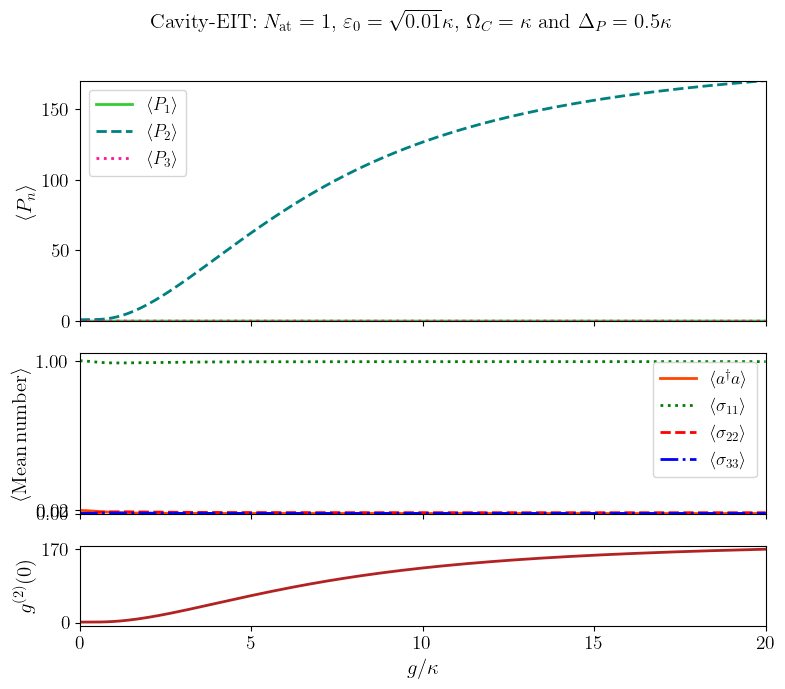

In [38]:
#Plot: epsilon=sqrt{0.01}*kappa, Nat=1 -> projections, mean number and correlation function

A1 = np.loadtxt(
    '/home/solakerino/Área de Trabalho/IC/results_cluster_backup/Código 3.0 (atual)/data/system_dynamics/Projections/MeanNumberxg_Nat1_ep001_Oc1_Dp05.csv', delimiter=',')


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(2.5*3.54,2.0*3.54),
                                    gridspec_kw={'width_ratios': [1],'height_ratios': [12, 8, 4],
                       'wspace': 0.4,
                       'hspace': 0.2},tight_layout=True)

ax1.plot(A1[:,0], A1[:,4],color='limegreen',linestyle='solid',lw=2)
ax1.plot(A1[:,0], A1[:,5],color='teal',linestyle='dashed',lw=2)
ax1.plot(A1[:,0], A1[:,6],color='deeppink',linestyle='dotted',lw=2)
ax1.set_ylabel(r'$\langle P_n \rangle$')
ax1.set_xticks([0,5.0,10.0,15.0,20.0])
#ax1.set_yticks([0,max(A1[:,6]),max(A1[:,5]),max(A1[:,4])])
ax1.set_ylim([0,max(A1[:,5])])
ax1.legend([r'$\langle P_{1} \rangle$', r'$\langle P_{2} \rangle$', r'$\langle P_{3} \rangle$']) 
ax1.label_outer()


ax2.plot(A1[:,0], A1[:,1] ,color='orangered',linestyle='solid',lw=2)
ax2.plot(A1[:,0], A1[:,2] ,color='green',linestyle='dotted',lw=2)
ax2.plot(A1[:,0], A1[:,3] ,color='red',linestyle='dashed',lw=2)
ax2.plot(A1[:,0], A1[:,4] ,color='blue',linestyle='dashdot',lw=2)
ax2.set_ylabel(r'$\langle \mathrm{Mean \, number} \rangle$')
ax2.set_xlabel(r'$g/\kappa$')
ax2.legend([r'$\langle a^\dagger a \rangle$', r'$\langle \sigma_{11}\rangle$',r'$\langle \sigma_{22}\rangle$',r'$\langle \sigma_{33}\rangle$']) 
ax2.set_yticks([0,max(A1[:,1]),max(A1[:,2])])
ax2.set_ylim([0,1.05])
ax2.set_xticks([0,5.0,10.0,15.0,20.0])
#ax2.set_xlim([0.05,10.0])
ax2.label_outer()

ax3.plot(A1[:,0], A1[:,5],color='firebrick',linestyle='solid',lw=2)
ax3.set_xlabel(r'$g/\kappa$')
ax3.set_ylabel(r'$g^{(2)}(0)$')
#ax3.set_ylim([0.0,1.2*max(M2[:,12])])
ax3.set_xlim([0.0,20.0])
ax3.set_xticks([0,5.0,10.0,15.0,20.0])
ax3.set_yticks([0,max(A1[:,5])])
ax3.set_xlabel(r'$g/\kappa$')
ax3.label_outer()

plt.suptitle(r'Cavity-EIT: $N_{\mathrm{at}}=1$, $\varepsilon_0=\sqrt{0.01}\kappa$, $\Omega_C=\kappa$ and $\Delta_P=0.5\kappa$', fontsize=15)
#fig.savefig('Projectionsxg_Nat1_ep001.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_4593/1321553745.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('Projectionsxg_Nat2_ep001.png', format='png', dpi=600)
/home/solakerino/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


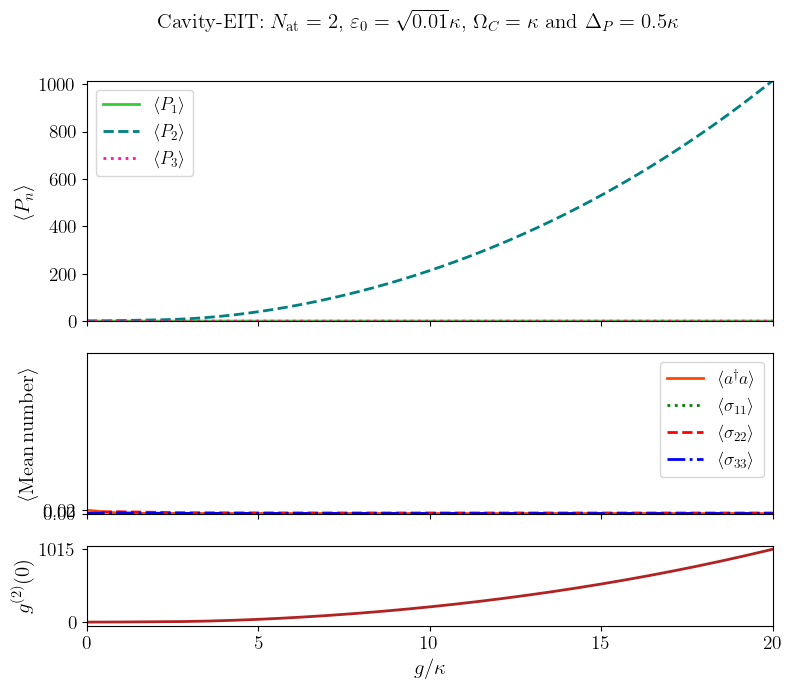

In [27]:
#Plot: epsilon=sqrt{0.01}*kappa, Nat=2 -> projections, mean number and correlation function

A1 = np.loadtxt(
    '/home/solakerino/Área de Trabalho/IC/results_cluster_backup/Código 3.0 (atual)/data/system_dynamics/Projections/MeanNumberxg_Nat2_ep001_Oc1_Dp05.csv', delimiter=',')


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(2.5*3.54,2.0*3.54),
                                    gridspec_kw={'width_ratios': [1],'height_ratios': [12, 8, 4],
                       'wspace': 0.4,
                       'hspace': 0.2},tight_layout=True)

ax1.plot(A1[:,0], A1[:,4],color='limegreen',linestyle='solid',lw=2)
ax1.plot(A1[:,0], A1[:,5],color='teal',linestyle='dashed',lw=2)
ax1.plot(A1[:,0], A1[:,6],color='deeppink',linestyle='dotted',lw=2)
ax1.set_ylabel(r'$\langle P_n \rangle$')
ax1.set_xticks([0,5.0,10.0,15.0,20.0])
#ax1.set_yticks([0,max(A1[:,6]),max(A1[:,5]),max(A1[:,4])])
ax1.set_ylim([0,max(A1[:,5])])
ax1.legend([r'$\langle P_{1} \rangle$', r'$\langle P_{2} \rangle$', r'$\langle P_{3} \rangle$']) 
ax1.label_outer()


ax2.plot(A1[:,0], A1[:,1] ,color='orangered',linestyle='solid',lw=2)
ax2.plot(A1[:,0], A1[:,2] ,color='green',linestyle='dotted',lw=2)
ax2.plot(A1[:,0], A1[:,3] ,color='red',linestyle='dashed',lw=2)
ax2.plot(A1[:,0], A1[:,4] ,color='blue',linestyle='dashdot',lw=2)
ax2.set_ylabel(r'$\langle \mathrm{Mean \, number} \rangle$')
ax2.set_xlabel(r'$g/\kappa$')
ax2.legend([r'$\langle a^\dagger a \rangle$', r'$\langle \sigma_{11}\rangle$',r'$\langle \sigma_{22}\rangle$',r'$\langle \sigma_{33}\rangle$']) 
ax2.set_yticks([0,max(A1[:,1]),max(A1[:,2])])
ax2.set_ylim([0,1.05])
ax2.set_xticks([0,5.0,10.0,15.0,20.0])
#ax2.set_xlim([0.05,10.0])
ax2.label_outer()

ax3.plot(A1[:,0], A1[:,5],color='firebrick',linestyle='solid',lw=2)
ax3.set_xlabel(r'$g/\kappa$')
ax3.set_ylabel(r'$g^{(2)}(0)$')
#ax3.set_ylim([0.0,1.2*max(M2[:,12])])
ax3.set_xlim([0.0,20.0])
ax3.set_xticks([0,5.0,10.0,15.0,20.0])
ax3.set_yticks([0,max(A1[:,5])])
ax3.set_xlabel(r'$g/\kappa$')
ax3.label_outer()

plt.suptitle(r'Cavity-EIT: $N_{\mathrm{at}}=2$, $\varepsilon_0=\sqrt{0.01}\kappa$, $\Omega_C=\kappa$ and $\Delta_P=0.5\kappa$', fontsize=15)
fig.savefig('Projectionsxg_Nat2_ep001.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_7622/3717272551.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('Projectionsxg_Nat1_ep01.png', format='png', dpi=600)
/home/solakerino/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


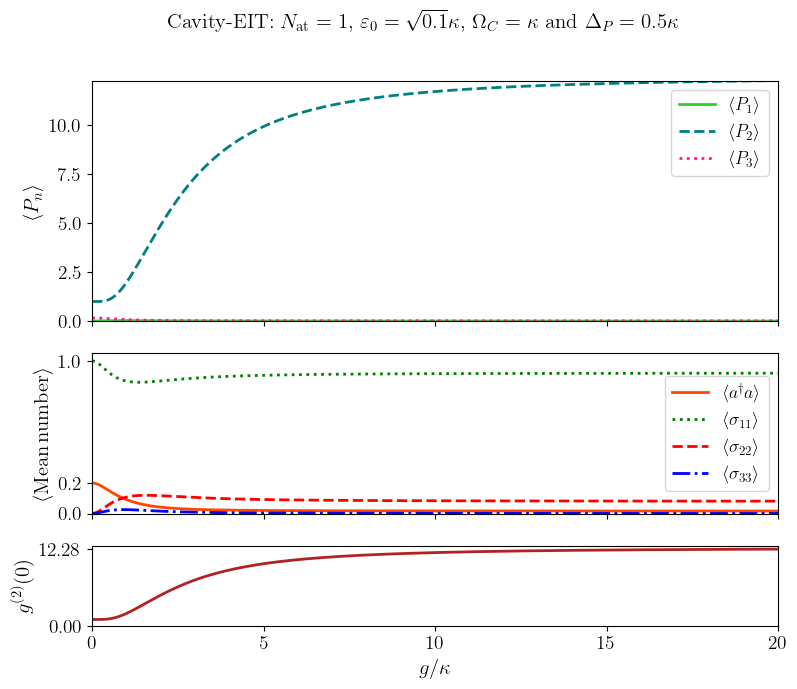

In [76]:
#Plot: epsilon=sqrt{0.1}*kappa -> projections, mean number and correlation function

A1 = np.loadtxt(
    '/home/solakerino/Área de Trabalho/IC/results_cluster_backup/Código 3.0 (atual)/data/system_dynamics/Projections/MeanNumberxg_Nat1_ep01_Oc1_Dp05.csv', delimiter=',')


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(2.5*3.54,2.0*3.54),
                                    gridspec_kw={'width_ratios': [1],'height_ratios': [12, 8, 4],
                       'wspace': 0.4,
                       'hspace': 0.2},tight_layout=True)

ax1.plot(A1[:,0], A1[:,4],color='limegreen',linestyle='solid',lw=2)
ax1.plot(A1[:,0], A1[:,5],color='teal',linestyle='dashed',lw=2)
ax1.plot(A1[:,0], A1[:,6],color='deeppink',linestyle='dotted',lw=2)
ax1.set_ylabel(r'$\langle P_n \rangle$')
ax1.set_xticks([0,5.0,10.0,15.0,20.0])
#ax1.set_yticks([0,max(A1[:,6]),max(A1[:,5]),max(A1[:,4])])
ax1.set_ylim([0,max(A1[:,5])])
ax1.legend([r'$\langle P_{1} \rangle$', r'$\langle P_{2} \rangle$', r'$\langle P_{3} \rangle$']) 
ax1.label_outer()


ax2.plot(A1[:,0], A1[:,1] ,color='orangered',linestyle='solid',lw=2)
ax2.plot(A1[:,0], A1[:,2] ,color='green',linestyle='dotted',lw=2)
ax2.plot(A1[:,0], A1[:,3] ,color='red',linestyle='dashed',lw=2)
ax2.plot(A1[:,0], A1[:,4] ,color='blue',linestyle='dashdot',lw=2)
ax2.set_ylabel(r'$\langle \mathrm{Mean \, number} \rangle$')
ax2.set_xlabel(r'$g/\kappa$')
ax2.legend([r'$\langle a^\dagger a \rangle$', r'$\langle \sigma_{11}\rangle$',r'$\langle \sigma_{22}\rangle$',r'$\langle \sigma_{33}\rangle$']) 
ax2.set_yticks([0,max(A1[:,1]),max(A1[:,2])])
ax2.set_ylim([0,1.05])
ax2.set_xticks([0,5.0,10.0,15.0,20.0])
#ax2.set_xlim([0.05,10.0])
ax2.label_outer()

ax3.plot(A1[:,0], A1[:,5],color='firebrick',linestyle='solid',lw=2)
ax3.set_xlabel(r'$g/\kappa$')
ax3.set_ylabel(r'$g^{(2)}(0)$')
#ax3.set_ylim([0.0,1.2*max(M2[:,12])])
ax3.set_xlim([0.0,20.0])
ax3.set_xticks([0,5.0,10.0,15.0,20.0])
ax3.set_yticks([0,max(A1[:,5])])
ax3.set_xlabel(r'$g/\kappa$')
ax3.label_outer()

plt.suptitle(r'Cavity-EIT: $N_{\mathrm{at}}=1$, $\varepsilon_0=\sqrt{0.1}\kappa$, $\Omega_C=\kappa$ and $\Delta_P=0.5\kappa$', fontsize=15)
fig.savefig('Projectionsxg_Nat1_ep01.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_7622/1900319353.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('Projectionsxg_Nat1_ep1_Oc20.png', format='png', dpi=600)
/home/solakerino/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


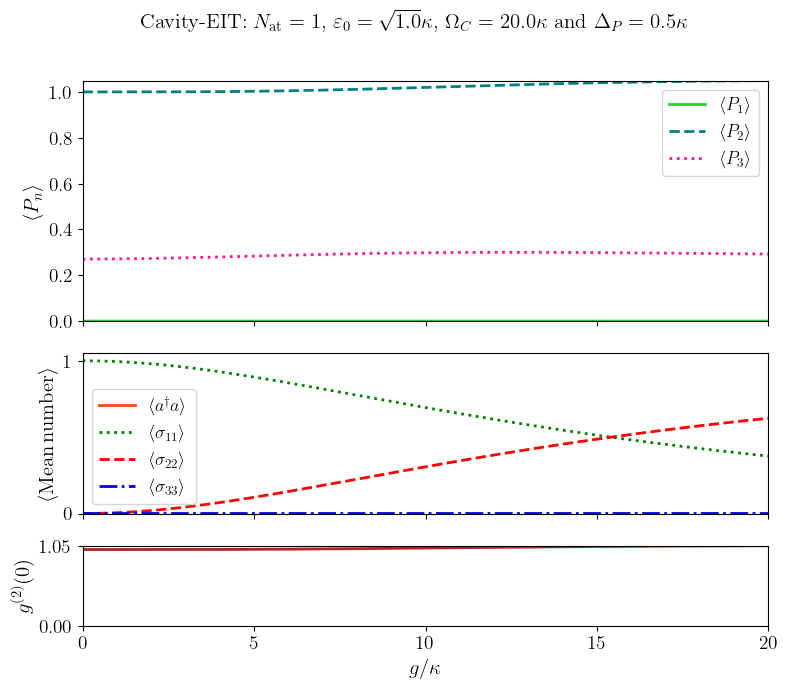

In [100]:
#Plot: epsilon=sqrt{1.0}*kappa -> projections, mean number and correlation function

A1 = np.loadtxt(
    '/home/solakerino/Área de Trabalho/IC/results_cluster_backup/Código 3.0 (atual)/data/system_dynamics/Projections/MeanNumberxg_Nat1_ep1_Oc20_Dp05.csv', delimiter=',')


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(2.5*3.54,2.0*3.54),
                                    gridspec_kw={'width_ratios': [1],'height_ratios': [12, 8, 4],
                       'wspace': 0.4,
                       'hspace': 0.2},tight_layout=True)

ax1.plot(A1[:,0], A1[:,4],color='limegreen',linestyle='solid',lw=2)
ax1.plot(A1[:,0], A1[:,5],color='teal',linestyle='dashed',lw=2)
ax1.plot(A1[:,0], A1[:,6],color='deeppink',linestyle='dotted',lw=2)
ax1.set_ylabel(r'$\langle P_n \rangle$')
ax1.set_xticks([0,5.0,10.0,15.0,20.0])
#ax1.set_yticks([0,max(A1[:,6]),max(A1[:,5]),max(A1[:,4])])
ax1.set_ylim([0,max(A1[:,5])])
ax1.legend([r'$\langle P_{1} \rangle$', r'$\langle P_{2} \rangle$', r'$\langle P_{3} \rangle$']) 
ax1.label_outer()


ax2.plot(A1[:,0], A1[:,1] ,color='orangered',linestyle='solid',lw=2)
ax2.plot(A1[:,0], A1[:,2] ,color='green',linestyle='dotted',lw=2)
ax2.plot(A1[:,0], A1[:,3] ,color='red',linestyle='dashed',lw=2)
ax2.plot(A1[:,0], A1[:,4] ,color='blue',linestyle='dashdot',lw=2)
ax2.set_ylabel(r'$\langle \mathrm{Mean \, number} \rangle$')
ax2.set_xlabel(r'$g/\kappa$')
ax2.legend([r'$\langle a^\dagger a \rangle$', r'$\langle \sigma_{11}\rangle$',r'$\langle \sigma_{22}\rangle$',r'$\langle \sigma_{33}\rangle$']) 
ax2.set_yticks([0,max(A1[:,1]),max(A1[:,2])])
ax2.set_ylim([0,1.05])
ax2.set_xticks([0,5.0,10.0,15.0,20.0])
#ax2.set_xlim([0.05,10.0])
ax2.label_outer()

ax3.plot(A1[:,0], A1[:,5],color='firebrick',linestyle='solid',lw=2)
ax3.set_xlabel(r'$g/\kappa$')
ax3.set_ylabel(r'$g^{(2)}(0)$')
#ax3.set_ylim([0.0,1.2*max(M2[:,12])])
ax3.set_xlim([0.0,20.0])
ax3.set_xticks([0,5.0,10.0,15.0,20.0])
ax3.set_yticks([0,max(A1[:,5])])
ax3.set_xlabel(r'$g/\kappa$')
ax3.label_outer()

plt.suptitle(r'Cavity-EIT: $N_{\mathrm{at}}=1$, $\varepsilon_0=\sqrt{1.0}\kappa$, $\Omega_C=20.0\kappa$ and $\Delta_P=0.5\kappa$', fontsize=15)
fig.savefig('Projectionsxg_Nat1_ep1_Oc20.png', format='png', dpi=600)
plt.show()